# Removing week-day effects and reporting delays

In [1]:
# | default_exp model

In [2]:
import jax

jax.config.update("jax_enable_x64", True)

In [3]:
# | export
import jax.numpy as jnp
import jax.scipy as jsp
import jax
from jax import vmap, jit
import matplotlib.pyplot as plt
import matplotlib as mpl

from isssm.typing import PGSSM, GLSSMState
from jaxtyping import Array, Float

from tensorflow_probability.substrates.jax.distributions import (
    NegativeBinomial as NBinom,
)

In [4]:
mpl.rcParams["figure.figsize"] = (20, 6)

## States

We consider states $X_t = \left(\log I_{t}, W_t, \dots, W_{t - 5}, q_{1,t}, q_{2,t}, q_{3,t}, \dots, q_{1, t-6}, \dots, q_{3, t - 6}\right)$ with

- $\log I_{t + 1} = \log I_{t} + \log \rho_{t}$
- $\log \rho_{t + 1} = \log \rho_{t} + \varepsilon^{\rho}_{t + 1}$
- $W_{t + 1} = - \sum_{s = 0}^5 W_{t - s} + \varepsilon^W_{t + 1}$ , $\varepsilon^W_{t + 1} \sim \mathcal N(0, \sigma^2_W)$
- $q_{i,t + 1} = q_{i, t-6} + \varepsilon_{t + 1}^{q,i}$; $i = 1,2,3$


Observations are the breakdown of incidences with Meldedatum $t$ into the delays $i = 1, \dots$. Note that on date $t$, $Y_t$ is only partially observed:
$$
Y^i_{t} \sim \operatorname{NBinom} \left( p_{i,t}\exp \left( W_{t} + \log I_{t} \right), r \right) = \operatorname{NBinom} \left( p_{i,t} \exp(W_{t}) I_{t}, r \right),
$$
for $i = 1,\dots, 4$, where the parametrization is such that the first parameter is the mean, the second the overdispersion parameter.

Here 
$$
    %p_{i,t} = \frac{\exp \left( q_{i,t} \right)}{\sum_{j = 1}^{4}\exp \left( q_{j,t} \right)}.
    p_{i,t} = \frac{\exp \left( q_{i,t} \right)}{1 + \sum_{j = 1}^{3}\exp \left( q_{j,t} \right)},
$$
for $i = 1, 2, 3$ and 
$$
    p_{4, t} = \frac{1}{1 + \sum_{j = 1}^{3}\exp \left( q_{j,t} \right)},
$$
similar as in Multinomial logistic regression.

We let 
$$
    \begin{align*}
    S_{t} &= B_{t}X_{t} \\
    &= \left( \log I_{t} + \log W_{t}, q_{1,t}, q_{2,t}, q_{3, t}\right)
    \end{align*}
$$

Now 
$$
    Y_{t}^i | S_{t} \sim \operatorname{NBinom} \left( p_{i,t}\exp \left( \log I_{t} + \log W_{t} \right), r \right).
$$
Note the following:

- $Y_t^i$ depends on all signals, not just on one, however the observations are still conditionally independent


The parameter $\theta$ of this model is 
$$
    \theta = \left( \log \sigma^{2}_{\log \rho}, \log \sigma^{2}_{W}, \log \sigma^{2}_q , \log r\right).
$$


In [5]:
# Model
from isssm.typing import PGSSM
import jax.scipy.linalg as jsla
from tensorflow_probability.substrates.jax.distributions import Poisson


def _model(theta, aux):
    # theta on log scale
    s2_log_r, s2_W, s2_q = jnp.exp(theta)
    np1, n_delay, r = aux

    n = np1 - 1
    m = 2 + 6 + 7 * (n_delay - 1)
    p = n_delay
    l = 2 + (n_delay - 1)

    # states
    u = jnp.zeros((np1, m))

    A_I_rho = jnp.array([[1.0, 1.0], [0.0, 1.0]])
    A_W = jnp.array(
        [
            [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0],
            [1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
        ]
    )

    A_q = jnp.block(
        [
            [jnp.zeros((n_delay - 1, 6 * (n_delay - 1))), jnp.eye(n_delay - 1)],
            [jnp.eye(6 * (n_delay - 1)), jnp.zeros((6 * (n_delay - 1), n_delay - 1))],
        ]
    )
    A = jsla.block_diag(A_I_rho, A_W, A_q)
    v = jnp.zeros((np1, p))

    D = jnp.eye(m)[:, jnp.array([1, 2, *jnp.arange(2 + 6, 2 + 6 + n_delay - 1)])]

    Sigma = jnp.diag(jnp.array([s2_log_r, s2_W, *jnp.repeat(s2_q, n_delay - 1)]))

    # initial u negative for q_t,i
    u0 = jnp.zeros(m).at[8:].set(-5.0)
    u = u.at[0].set(u0)
    # large initial variance, diffuse initialization
    Sigma0 = jsla.block_diag(
        25 * jnp.eye(1),  # log I,
        1 * jnp.eye(1),  # log rho,
        10 * jnp.eye(6),  # W
        10 * jnp.eye(7 * (n_delay - 1)),  # q
    )

    B = jnp.hstack(
        [
            jnp.eye(n_delay)[:, :1],  # log I
            jnp.zeros((n_delay, 1)),  # log rho
            jnp.eye(n_delay)[:, :1],  # W_t
            jnp.zeros((n_delay, 5)),  # W_t-s
            jnp.eye(n_delay)[:, 1:],  # q
            jnp.zeros((n_delay, 6 * (n_delay - 1))),  # q_t-s
        ]
    )

    A = jnp.broadcast_to(A, (n, m, m))
    D = jnp.broadcast_to(D, (n, m, l))
    Sigma = jnp.broadcast_to(Sigma, (n, l, l))
    B = jnp.broadcast_to(B, (np1, p, m))

    def poisson_obs(s, xi):
        log_I_W, q = jnp.split(s, [1], axis=-1)
        exp_q = jnp.exp(q)
        p_n_delay = 1 / (1 + exp_q.sum(axis=-1, keepdims=True))
        log_p = jnp.log(jnp.concatenate([exp_q * p_n_delay, p_n_delay], axis=-1))
        log_rate = log_I_W + log_p
        return Poisson(log_rate=log_rate)

    def negbinom_obs(s, xi):
        log_I_W, q = jnp.split(s, [1], axis=-1)
        exp_q = jnp.exp(q)
        p_n_delay = 1 / (1 + exp_q.sum(axis=-1, keepdims=True))
        log_p = jnp.log(jnp.concatenate([exp_q * p_n_delay, p_n_delay], axis=-1))
        log_mu = log_I_W + log_p
        return NBinom(r, logits=log_mu - jnp.log(r))

    dist = poisson_obs
    xi = jnp.empty((np1, p))

    return PGSSM(u, A, D, Sigma0, Sigma, v, B, dist, xi)

The `isssm.laplace_approximation` module assumes that $y_{t,i}$ only depends on $\theta_{t,i}$ which is not the case here. To fix this, we monkey-patch both the LA and MEIS.

In [6]:
# LA monkey patch
from isssm.kalman import kalman, smoothed_signals
from isssm.typing import GLSSM, GLSSMProposal, ConvergenceInformation
from isssm.laplace_approximation import default_link, vvmap, vdiag
from jax.scipy.optimize import minimize
from functools import partial
from isssm.util import converged
from jax import jacfwd, hessian, jacrev
from jax.lax import while_loop
import isssm.laplace_approximation


def _initial_guess(xi_t, y_t, dist, link=default_link):
    result = minimize(
        lambda s_ti: -dist(s_ti, xi_t).log_prob(y_t).sum(),
        jnp.concatenate((jnp.atleast_1d(link(y_t.sum())), jnp.zeros(3))),
        method="BFGS",
    )
    return jnp.squeeze(result.x)


def laplace_approximation(
    y: Float[Array, "n+1 p"],  # observation
    model: PGSSM,
    n_iter: int,  # number of iterations
    log_lik=None,  # log likelihood function
    d_log_lik=None,  # derivative of log likelihood function
    dd_log_lik=None,  # second derivative of log likelihood function
    eps: Float = 1e-5,  # precision of iterations
    link=default_link,  # default link to use in initial guess
) -> tuple[GLSSMProposal, ConvergenceInformation]:
    u, A, D, Sigma0, Sigma, v, B, dist, xi = model
    np1, p, m = B.shape

    s_init = vmap(partial(_initial_guess, dist=dist, link=link))(xi, y)

    def default_log_lik(
        s_t: Float[Array, "p"], xi_t: Float[Array, "p"], y_t: Float[Array, "p'"]
    ):
        return dist(s_t, xi_t).log_prob(y_t).sum()

    if log_lik is None:
        log_lik = default_log_lik

    if d_log_lik is None:
        d_log_lik = jacfwd(log_lik, argnums=0)
    if dd_log_lik is None:
        dd_log_lik = jacrev(d_log_lik, argnums=0)

    vd_log_lik = jit(vmap(d_log_lik))
    vdd_log_lik = jit(vmap(dd_log_lik))

    def _break(val):
        _, i, z, Omega, z_old, Omega_old = val

        z_converged = jnp.logical_and(converged(z, z_old, eps), i > 0)
        Omega_converged = jnp.logical_and(converged(Omega, Omega_old, eps), i > 0)
        all_converged = jnp.logical_and(z_converged, Omega_converged)

        iteration_limit_reached = i >= n_iter

        return jnp.logical_or(all_converged, iteration_limit_reached)

    def _iteration(val):
        s, i, z_old, Omega_old, _, _ = val

        grad = vd_log_lik(s, xi, y)
        Gamma = -vdd_log_lik(s, xi, y)
        Omega = jnp.linalg.inv(Gamma)

        # z = s + jnp.linalg.solve(Gamma, grad[..., None])[..., 0]
        z = s + vmap(jnp.matmul)(Omega, grad)
        approx_glssm = GLSSM(u, A, D, Sigma0, Sigma, v, B, Omega)

        filtered = kalman(z, approx_glssm)
        s_new = smoothed_signals(filtered, z, approx_glssm)

        return s_new, i + 1, z, Omega, z_old, Omega_old

    empty_z = jnp.empty_like(s_init)
    empty_Omega = jnp.empty((np1, p, p))
    init = (s_init, 0, empty_z, empty_Omega, empty_z, empty_Omega)

    _keep_going = lambda *args: jnp.logical_not(_break(*args))
    _, n_iters, z, Omega, z_old, Omega_old = while_loop(_keep_going, _iteration, init)

    final_proposal = GLSSMProposal(u, A, D, Sigma0, Sigma, v, B, Omega, z)
    delta_z = jnp.max(jnp.abs(z - z_old))
    delta_Omega = jnp.max(jnp.abs(Omega - Omega_old))
    information = ConvergenceInformation(
        converged=jnp.logical_and(
            converged(z, z_old, eps), converged(Omega, Omega_old, eps)
        ),
        n_iter=n_iters,
        delta=jnp.max(jnp.array([delta_z, delta_Omega])),
    )
    return final_proposal, information


isssm.laplace_approximation.laplace_approximation = laplace_approximation

In [7]:
# MEIS monkey patch
import jax.random as jrn
from jaxtyping import PRNGKeyArray
from isssm.importance_sampling import normalize_weights, log_weights_t
from isssm.kalman import simulation_smoother
import isssm.modified_efficient_importance_sampling


def triu(entries: Float[Array, " q"], p: int):
    (q,) = entries.shape

    if 2 * q != p * (p + 1):
        raise ValueError(
            f"entries does not have the correct shape, expected {int(p * (p - 1) /2)} entries in the second dimension but got {q}"
        )

    mat = jnp.zeros((p, p))
    mat = mat.at[jnp.triu_indices(p)].set(entries)

    return mat


def tril(entries: Float[Array, " q"], p: int):
    (q,) = entries.shape

    if 2 * q != p * (p + 1):
        raise ValueError(
            f"entries does not have the correct shape, expected {int(p * (p - 1) /2)} entries in the second dimension but got {q}"
        )

    mat = jnp.zeros((p, p))
    mat = mat.at[jnp.tril_indices(p)].set(entries)

    return mat


@jit
def optimal_parameters(
    signal: Float[Array, "N p"], weights: Float[Array, "N"], log_p: Float[Array, "N"]
):
    N, p = signal.shape
    ones = jnp.ones_like(weights)[:, None]
    w_inner_prod = lambda a, b: jnp.einsum("i,ij,ik->jk", weights, a, b)

    second_moment = vmap(jnp.outer)(signal, signal)
    # double tranpose, because [:, jnp.tril_indices(p)] is not supported (returns (N, 2, p(p-1)/2, 4) instead of (N, p(p-1)/2)
    lower_tri_second_moment = second_moment.transpose((1, 2, 0))[jnp.tril_indices(p)].T

    X_T_W_X = jnp.block(
        [
            [
                w_inner_prod(ones, ones),
                w_inner_prod(ones, signal),
                w_inner_prod(ones, -0.5 * lower_tri_second_moment),
            ],
            [
                w_inner_prod(signal, ones),
                w_inner_prod(signal, signal),
                w_inner_prod(signal, -0.5 * lower_tri_second_moment),
            ],
            [
                w_inner_prod(-0.5 * lower_tri_second_moment, ones),
                w_inner_prod(-0.5 * lower_tri_second_moment, signal),
                w_inner_prod(
                    -0.5 * lower_tri_second_moment, -0.5 * lower_tri_second_moment
                ),
            ],
        ]
    )
    X_T_W_y = jnp.concatenate(
        [
            w_inner_prod(ones, log_p[:, None]),
            w_inner_prod(signal, log_p[:, None]),
            w_inner_prod(-0.5 * lower_tri_second_moment, log_p[:, None]),
        ]
    )

    beta = jnp.linalg.solve(X_T_W_X, X_T_W_y[:, 0])
    return beta


def modified_efficient_importance_sampling(
    y: Float[Array, "n+1 p"],  # observations
    model: PGSSM,  # model
    z_init: Float[Array, "n+1 p"],  # initial z estimate
    Omega_init: Float[Array, "n+1 p p"],  # initial Omega estimate
    n_iter: int,  # number of iterations
    N: int,  # number of samples
    key: PRNGKeyArray,  # random key
    eps: Float = 1e-5,  # convergence threshold
):
    z, Omega = z_init, Omega_init

    np1, p, m = model.B.shape

    key, crn_key = jrn.split(key)

    v_norm_w = vmap(normalize_weights)
    dist = model.dist
    lw_t = vmap(
        vmap(lambda s, y, xi, z, Omega: log_weights_t(s, y, xi, dist, z, Omega)),
        (0, None, None, None, None),
    )

    def _break(val):
        i, z, Omega, z_old, Omega_old = val

        # in first iteration we don't have old values, converged is True for NaNs
        z_converged = jnp.logical_and(converged(z, z_old, eps), i > 0)
        Omega_converged = jnp.logical_and(converged(Omega, Omega_old, eps), i > 0)
        iteration_limit_reached = i >= n_iter

        return jnp.logical_or(
            jnp.logical_and(z_converged, Omega_converged), iteration_limit_reached
        )

    def _iteration(val):
        i, z, Omega, _, _ = val
        glssm_approx = GLSSM(
            model.u,
            model.A,
            model.D,
            model.Sigma0,
            model.Sigma,
            model.v,
            model.B,
            Omega,
        )
        sim_signal = simulation_smoother(glssm_approx, z, N, crn_key)

        log_weights = lw_t(sim_signal, y, model.xi, z, Omega)
        log_p = dist(sim_signal, model.xi).log_prob(y).sum(axis=-1)
        wls_estimate = vmap(optimal_parameters, (1, 1, 1), 0)(
            sim_signal, v_norm_w(log_weights), log_p
        )

        a = wls_estimate[:, 0]
        b = wls_estimate[:, 1 : (p + 1)]
        c = wls_estimate[:, (p + 1) :]

        Omega_inv_new = vmap(tril, (0, None))(c, p)
        Omega_inv_new = 1 / 2 * (Omega_inv_new + Omega_inv_new.transpose((0, 2, 1)))
        z_new = jnp.linalg.solve(Omega_inv_new, b)
        Omega_new = jnp.linalg.inv(Omega_inv_new)

        return i + 1, z_new, Omega_new, z, Omega

    _keep_going = lambda *args: jnp.logical_not(_break(*args))

    init = (0, z_init, Omega_init, jnp.empty_like(z_init), jnp.empty_like(Omega_init))
    n_iters, z, Omega, z_old, Omega_old = while_loop(_keep_going, _iteration, init)

    proposal = GLSSMProposal(
        model.u, model.A, model.D, model.Sigma0, model.Sigma, model.v, model.B, Omega, z
    )

    delta_z = jnp.max(jnp.abs(z - z_old))
    delta_Omega = jnp.max(jnp.abs(Omega - Omega_old))
    information = ConvergenceInformation(
        converged=jnp.logical_and(
            converged(z, z_old, eps), converged(Omega, Omega_old, eps)
        ),
        n_iter=n_iters,
        delta=jnp.max(jnp.array([delta_z, delta_Omega])),
    )

    return proposal, information


isssm.modified_efficient_importance_sampling.modified_efficient_importance_sampling = (
    modified_efficient_importance_sampling
)

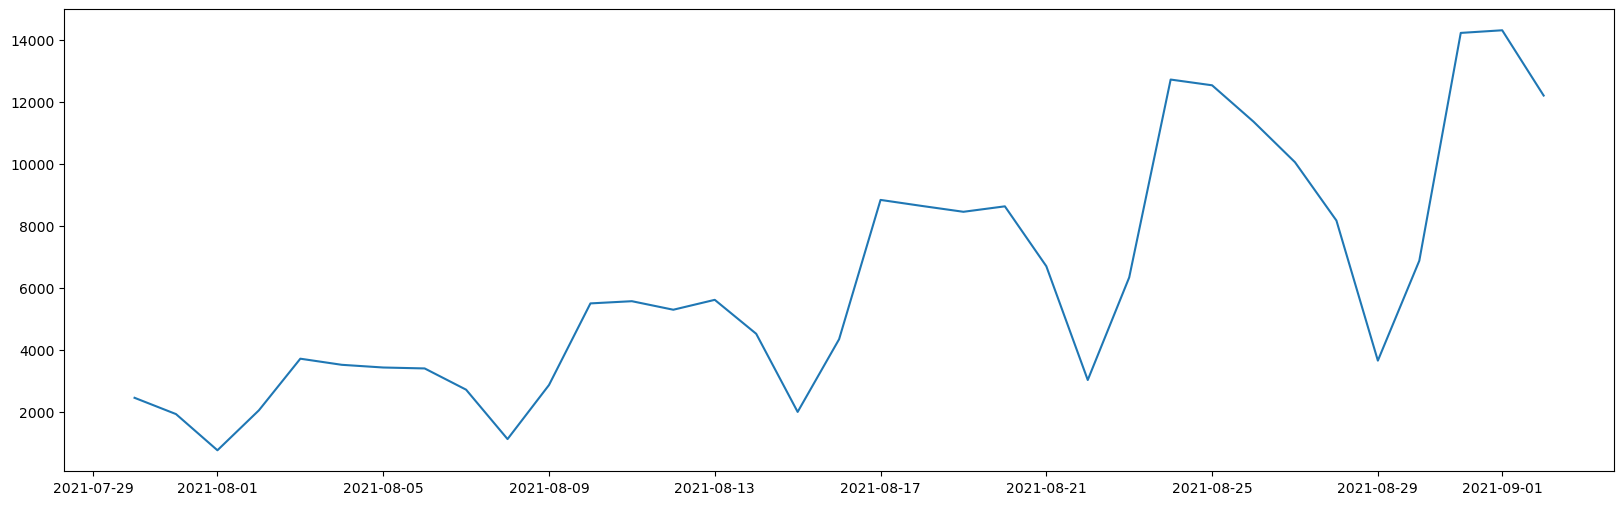

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../../../data/processed/RKI_4day_rt.csv")
i_start = 480
n = 5 * 7
data_selected = df.iloc[i_start : i_start + n, 1:]
dates = pd.to_datetime(df.iloc[i_start : i_start + n, 0])
y_t = jnp.asarray(data_selected.to_numpy())

plt.plot(dates, y_t.sum(axis=1))

plt.show()

In [9]:
from isssm.modified_efficient_importance_sampling import (
    modified_efficient_importance_sampling as MEIS,
)
from isssm.importance_sampling import pgssm_importance_sampling, ess_pct
from jax import random as jrn

theta_init = jnp.log(
    # s2_log_rho, s2_W, s2_q,
    jnp.array([0.1**2, 0.1**2, 0.5**2])
)

aux = (n, 4, 1e5)
pgssm = _model(theta_init, aux)

proposal_la, info_la = laplace_approximation(y_t, pgssm, 10000)
key = jrn.PRNGKey(34234234)
key, subkey = jrn.split(key)


samples, log_weights = pgssm_importance_sampling(
    y_t, pgssm, proposal_la.z, proposal_la.Omega, 10000, subkey
)

ess_pct(log_weights), info_la

(Array(0.01459852, dtype=float64),
 ConvergenceInformation(converged=Array(False, dtype=bool), n_iter=Array(10000, dtype=int64, weak_type=True), delta=Array(7.99360578e-15, dtype=float64)))

In [10]:
proposal_meis, _ = MEIS(
    y_t, pgssm, proposal_la.z, proposal_la.Omega, 10, int(1e4), subkey
)

key, subkey = jrn.split(key)
samples, log_weights = pgssm_importance_sampling(
    y_t, pgssm, proposal_meis.z, proposal_meis.Omega, 10000, subkey
)

ess_pct(log_weights)

/opt/homebrew/Caskroom/miniconda/base/envs/research/lib/python3.10/site-packages/jax/_src/numpy/linalg.py:708: FutureWarning: jnp.linalg.solve: batched 1D solves with b.ndim > 1 are deprecated, and in the future will be treated as a batched 2D solve. Use solve(a, b[..., None])[..., 0] to avoid this warning.
  warnings.warn("jnp.linalg.solve: batched 1D solves with b.ndim > 1 are deprecated, "


Array(36.24390285, dtype=float64)

In [11]:
from isssm.estimation import mle_pgssm, initial_theta

theta0 = initial_theta(y_t, _model, theta_init, aux, 20)
theta0

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 7.1262361951622175
        x: [-9.170e+00 -7.598e+00 -2.333e+00]
      nit: 17
      jac: [ 2.187e-06  5.415e-07  2.637e-06]
 hess_inv: [[ 5.759e+01 -1.929e+00  7.582e-01]
            [-1.929e+00  2.166e+01 -1.963e-01]
            [ 7.582e-01 -1.963e-01  6.412e+00]]
     nfev: 140
     njev: 20

In [12]:
key, subkey = jrn.split(key)
theta_mle = mle_pgssm(y_t, _model, theta0.x, aux, 20, 1000, subkey)

In [ ]:
theta_mle

  message: NaN result encountered.
  success: False
   status: 3
      fun: nan
        x: [-9.170e+00 -7.598e+00 -2.333e+00]
      nit: 0
      jac: [       nan        nan        nan]
 hess_inv: [[1 0 0]
            [0 1 0]
            [0 0 1]]
     nfev: 7
     njev: 1

In [ ]:
# estimated SDs
jnp.exp(theta0.x / 2), jnp.exp(theta_mle.x / 2)

(Array([0.01020123, 0.02239668, 0.31152383], dtype=float64),
 Array([0.01020123, 0.02239668, 0.31152383], dtype=float64))

In [ ]:
fitted_model = _model(theta0.x, aux)

proposal_la, _ = laplace_approximation(y_t, fitted_model, 100)
key, subkey = jrn.split(key)
proposal_meis, _ = MEIS(
    y_t, fitted_model, proposal_la.z, proposal_la.Omega, 10, int(1e4), subkey
)

key, subkey = jrn.split(key)
samples_meis, log_weights_meis = pgssm_importance_sampling(
    y_t, fitted_model, proposal_meis.z, proposal_meis.Omega, 10000, subkey
)
key, subkey = jrn.split(key)
samples_la, log_weights_la = pgssm_importance_sampling(
    y_t, fitted_model, proposal_la.z, proposal_la.Omega, 10000, subkey
)
ess_pct(log_weights_la), ess_pct(log_weights_meis)

(Array(0.00260044, dtype=float64), Array(0.00517058, dtype=float64))

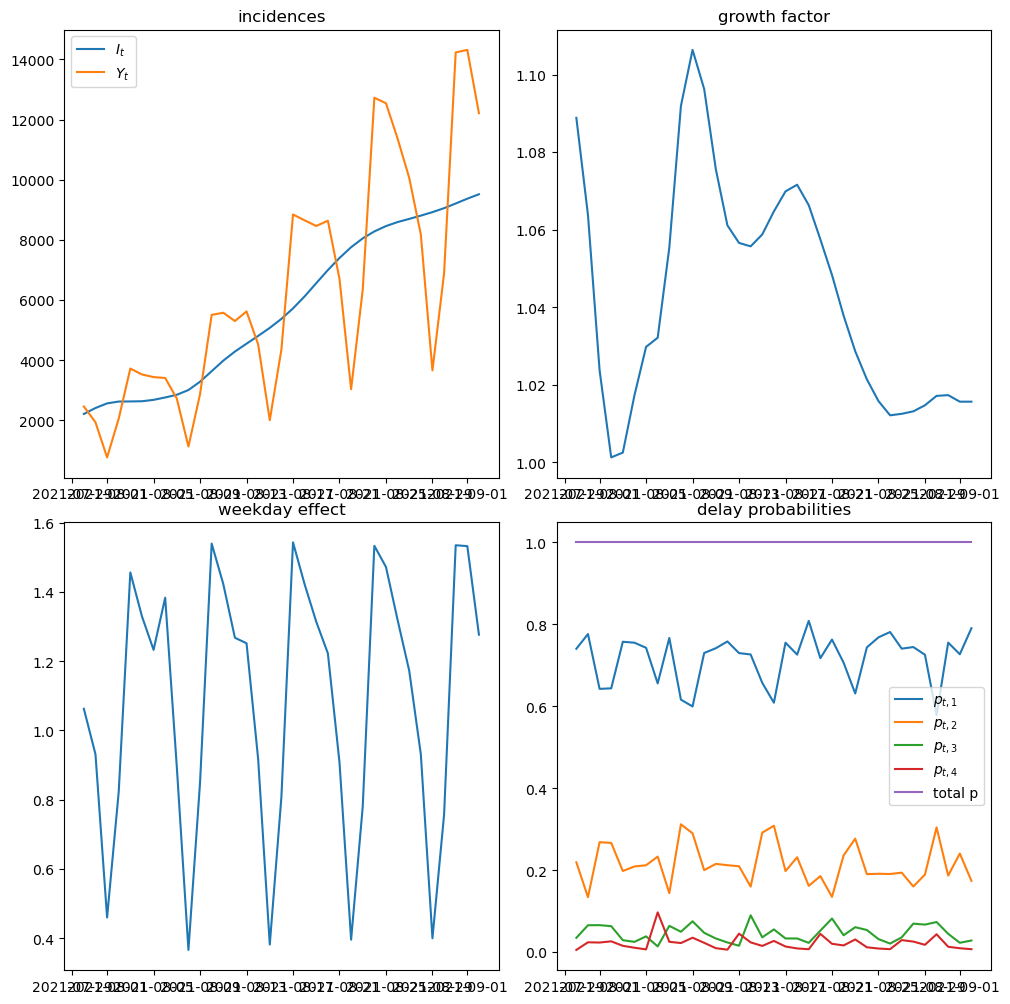

In [ ]:
from isssm.importance_sampling import normalize_weights
from isssm.typing import GLSSM
from isssm.kalman import kalman, smoother
from isssm.util import mm_time

signal_model = GLSSM(
    fitted_model.u,
    fitted_model.A,
    fitted_model.D,
    fitted_model.Sigma0,
    fitted_model.Sigma,
    fitted_model.v,
    fitted_model.B,
    jnp.zeros((n, 4, 4)),
)


def smooth_x(sample):
    return smoother(kalman(sample, signal_model), signal_model.A).x_smooth


x_smooth = (
    # vmap(smooth_x)(samples_la) * normalize_weights(log_weights_la)[:, None, None]
    vmap(smooth_x)(samples_meis)
    * normalize_weights(log_weights_meis)[:, None, None]
).sum(axis=0)

# plt.plot(jnp.exp(x_smooth[:, 12]), label="smoothed")
# plt.plot(jnp.exp(x_smooth[:, 2:8].sum(axis=1)), label="smoothed")
# plt.plot(jnp.exp(x_smooth[:, 0]), label="smoothed")
# plt.plot(y.sum(axis=1), label="Y")
# plt.plot(jnp.exp(x_smooth[:, 1]), label="smoothed")

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs = axs.flatten()
fig.tight_layout()

axs[0].set_title("incidences")
axs[0].plot(dates, jnp.exp(x_smooth[:, 0]), label="$I_t$")
axs[0].plot(dates, y_t.sum(axis=1), label="$Y_t$")
axs[0].legend()

axs[1].set_title("growth factor")
axs[1].plot(dates, jnp.exp(x_smooth[:, 1]), label="$\\rho_t$")

axs[2].set_title("weekday effect")
axs[2].plot(dates, jnp.exp(x_smooth[:, 2]), label="$S_t$")

axs[3].set_title("delay probabilities")


q = x_smooth[:, 8:11]
exp_q = jnp.exp(q)
p_n_delay = 1 / (1 + exp_q.sum(axis=-1, keepdims=True))
log_probs = jnp.log(jnp.concatenate([exp_q * p_n_delay, p_n_delay], axis=-1))

axs[3].plot(dates, jnp.exp(log_probs[:, 0]), label="$p_{t, 1}$")
axs[3].plot(dates, jnp.exp(log_probs[:, 1]), label="$p_{t, 2}$")
axs[3].plot(dates, jnp.exp(log_probs[:, 2]), label="$p_{t, 3}$")
axs[3].plot(dates, jnp.exp(log_probs[:, 3]), label="$p_{t, 4}$")
axs[3].plot(dates, jnp.exp(log_probs).sum(axis=1), label="total p")
axs[3].legend()
plt.show()

In [ ]:
from nbdev import export

export.nb_export("10_model.ipynb", "src")